# Introduction

The growth of internet over the last decade has brought along a revolution in the streaming industry. Number of websites which stream and broadcast video content has grown exponentially. YouTube was the leader of this new age and has over a billion videos now. Some videos make people laugh, some arouse anger, while some trigger the sadness deep down in our hearts. For the final project, we are interested in understanding the emotions and feelings behind each video. We would like to collect our own data and apply both supervised and unsupervised learning to label the videos. Then we would train a classifier to further predict the emotion of unseen videos


# Project Content
We will cover the following topics in this notebook:
* Installing the libraries
* Data Scraping using Youtube Data API
* Exploratory Data Analysis
* Getting Features
* Supervised - Getting Sentimental Labels from indico
* Unsupervised - Getting Labels by Emotion Dictionary
* Data Visualization
* Training and Prediction
* Recommendation System
* Conclusion & Reference


#Installing the libraries
Let's get started by installing the libraries we would use later. Our data comes from Youtube so we need to access the Youtube Data API.
> pip install --upgrade google-api-python-client

We will also be using [indico](https://indico.io/product/sentiment-analysis), a sentiment analysis library to label the emotions
> pip install indicoio

For visualization, we will use plotly to provide some insight into our data and classification results.
> pip install plotly 

In [4]:
import pandas as pd
import time
import numpy as np

import plotly.plotly as py
import plotly.graph_objs as go

import indicoio

from apiclient.discovery import build
from apiclient.errors import HttpError
from oauth2client.tools import argparser

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model
from scipy import sparse

from difflib import SequenceMatcher
from IPython.display import YouTubeVideo

# Data Scraping using Youtube Data API
We will be scraping textual information about Youtube videos instead of the videos itself. We believe that the title, description, tags, and comments would provide insight to what kinds of emotion a video makes people feel. Before accessing the Youtube Data API, first we need to enable the API and retrieve a credential key from the [Google Developers Console](https://console.developers.google.com/) .

Using this API, you are able to perform upload operations or retrieve all kinds of information related to a video. We will particularly be using the search command to perform a broad search based on video categories, and the video search command to get metatdata of a specific video. You need to pass the developer key whenever you access the API. More details of the usage can be found in the [documentation](https://developers.google.com/youtube/v3/getting-started)

Below is a simple example of how to use the search.list method:


In [5]:
'''
  Simple Example of Using youtube.search().list
'''
DEVELOPER_KEY = "USE_YOUR_OWN_KEY"
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"

def youtube_sample_search(query):

    youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION,developerKey=DEVELOPER_KEY)

    search_response = youtube.search().list(
      q=query,
      type="video",
      part="id,snippet", # Part signifies the different types of data you want 
      ).execute()
    
    for search_result in search_response.get("items", []):
      print("ID: " + search_result['id']['videoId'] + ", TITLE: " + search_result['snippet']['title'])

youtube_sample_search('trump')

ID: BAjzek9Ltg8, TITLE: If Donald Trump is Nominated for a Nobel Peace Prize
ID: 5N2TFZ-_Jkk, TITLE: Trump, Pence rally in Indiana
ID: MEC6Ai1Zfwc, TITLE: Wall Street thinks Trump’s speech was a placebo: Charles Payne
ID: 1rdm-bWNWYE, TITLE: President Donald Trump Pleases Insurers, Angers Critics With Drug-Pricing Plan | NBC Nightly News
ID: U4PXqdit6Ks, TITLE: Did an FBI spy infiltrate the Trump 2016 campaign?


Now we start scraping our own data. Because we want a diversed topic of videos, we search through all youtube categories to retrieve the top 500 videos each. Some categories include "Film & Animation", "Autos & Vehicles", "Music", "Pets & Animals", "Sports",...etc. Note that Youtube search returns result with a probability so it is limited to returning 500 results for each search. For each search results, we make another API call to get the textual information. We store all data in a .csv file.

In [7]:
'''
  Search for each youtube category and scrape data
'''
def youtube_search(id, token, max_results=50, order="relevance", location=None, location_radius=None):

    youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION,developerKey=DEVELOPER_KEY)

    search_response = youtube.search().list(
      type="video",
      pageToken=token,
      order = order,
      part="id,snippet", # Part signifies the different types of data you want 
      maxResults=max_results,
      location=location,
      videoCategoryId =id ,
      locationRadius=location_radius).execute()

    
    strList = []
    nextPageToken = search_response.get('nextPageToken')
 
    for search_result in search_response.get("items", []):

        response = youtube.videos().list(
            part='statistics, snippet',
            id=search_result['id']['videoId']).execute()

        strVideoData = ""
        likeCount = 'NA'
        dislikeCount = 'NA'
        viewCount = 'NA'
        if 'likeCount' in response['items'][0]['statistics'].keys():
            likeCount = response['items'][0]['statistics']['likeCount']

        if 'dislikeCount' in response['items'][0]['statistics'].keys():
            dislikeCount = response['items'][0]['statistics']['dislikeCount']

        if 'viewCount' in response['items'][0]['statistics'].keys():
            viewCount = response['items'][0]['statistics']['viewCount']

        description = response['items'][0]['snippet']['description']
        description = description.replace('\n', " ").replace('\r', ' ')
        strVideoData = search_result['id']['videoId'] + "\t" +search_result['snippet']['title']+"\t"+ description + "\t" + \
            response['items'][0]['snippet']['channelId'] + "\t" + response['items'][0]['snippet']['channelTitle'] + "\t" + \
            response['items'][0]['snippet']['categoryId'] + "\t" + response['items'][0]['statistics']['favoriteCount'] + "\t" + \
            viewCount + "\t" + likeCount + "\t" + dislikeCount 

        if 'commentCount' in response['items'][0]['statistics'].keys():
            strVideoData = strVideoData + "\t" + response['items'][0]['statistics']['commentCount']
        else:
            strVideoData = strVideoData + "\t" + ""
      
        if 'tags' in response['items'][0]['snippet'].keys():            
            strVideoData = strVideoData + "\t"
            for val in response['items'][0]['snippet']['tags']:
                strVideoData = strVideoData + val + ","
        else:
            strVideoData = strVideoData + "\t" + ""

        # Get comments
        try:
            response2 = youtube.commentThreads().list(
              part="snippet",
              videoId=search_result['id']['videoId'],
              textFormat="plainText"
              ).execute()
            authors = ""
            comments = ""

            i = 0
            if response2["items"] != None:
                for item in response2["items"]:
                    i += 1
                    comment = item["snippet"]["topLevelComment"]
                    author = comment["snippet"]["authorDisplayName"]
                    text = comment["snippet"]["textDisplay"]

                    authors = authors + author + ":"
                    comments = comments + text + ":"
                    if i == 10:
                        break
        except(HttpError) as e:
            authors = ""
            comments = ""
                
        strVideoData = strVideoData + "\t" + authors + "\t" + comments.replace('\n', " ").replace('\r', ' ') + "\n"
        strList.append(strVideoData)
        
    return nextPageToken, strList
    
    
    
def scrape_data():
    categories = [2,1,10,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44]
    f = open("youtube_all.csv", 'w')
    f.write('videoId\ttitle\tdescription\tchannelId\tchannelTitle\tcategoryId\tfavoriteCount\tviewCount\tlikeCount\tdislikeCount\tcommentCount\ttags\tauthor\tcomments\n')
    for category in categories:
        nextPageToken = ""
        tokens = {}

        while nextPageToken is not None:

            nextPageToken, strVideoDataList = youtube_search(category, nextPageToken)
            if nextPageToken not in tokens.keys():
                tokens[nextPageToken] = 1
                for val in strVideoDataList:
                    f.write(val)
    f.close()
    print("Done")
    
scrape_data()
df = pd.read_csv('youtube_all.csv', delimiter='\t', error_bad_lines=False, header=0, dtype=object)
df.head()

Done


,videoId,title,description,channelId,channelTitle,categoryId,favoriteCount,viewCount,likeCount,dislikeCount,commentCount,tags,author,comments
0,rBD7XVvJ02s,POKEMON IN REAL LIFE 3!,MORE POKEMON VIDEOS: https://youtu.be/4BO2HgT...,UCY30JRSgfhYXA6i6xX1erWg,Smosh,43,0,30167513,203626,4748,30710,"smosh,pokemon go,anthony,padilla,ian,hecox,pok...",Silvia Valbuena:MC TEEN:yip mam:lucutes /// Su...,Me gusta mucho el video es muy gracioso:I...
1,LfoGBVM86PM,POKEMON IN REAL LIFE 2!,MORE POKEMON VIDEOS: https://youtu.be/4BO2HgT...,UCY30JRSgfhYXA6i6xX1erWg,Smosh,43,0,39292642,274101,5714,48091,"smosh,pokemon go,anthony,padilla,ian,hecox,pok...",inkling 18:Matte Cartoon296:FireMario64:Arran ...,Monky pokedex manky ash monky pokedex manke lo...
2,dkHJKakHMpo,Annoying Orange - Wasssabi,🚨 NEW MERCH! http://amzn.to/annoyingorange 🚨 ➤...,UCi-5OZ2tYuwMLIcEyOsbdRA,Annoying Orange,43,0,38552990,132042,3757,23493,"annoying,orange,wazzup,sequel,wassup,wasabi,wa...",Fra 3c1sxX:virat Wisetsingh:Domc le chan:J&A y...,I LOVE SUSHI YUMMY:0:58 wasabi get squished by...
3,w0ffwDYo00Q,Cat Man Do - Simon's Cat | SHORTS,A hungry cat resorts to increasingly desperate...,UCH6vXjt-BA7QHl0KnfL-7RQ,Simon's Cat,43,0,60350864,259509,5405,16110,"pet,cat,humor,funny,comedy,animation,cartoon,s...",kala kana:TheMinimancjb34:Mridula Biswas:Sacre...,ten years.... :O:Simon it would be cool if you...
4,M06sWmoEk_A,TEENS IN THE WILD!,WATCH BLOOPERS & BONUS SCENES: http://bit.ly/t...,UCY30JRSgfhYXA6i6xX1erWg,Smosh,43,0,17514091,133238,3640,18376,"teen,teenager,teenagers,wildlife,hunting,docum...",Adithya Tatineni:Michael Odoherty:gray becker:...,Anthony’s channel is the worst it is so boring...


# Exploratory Data Analysis

Now that we have our scraped data from all the different categories, we would like to do some exploratory data analysis to see which category of videos get more popular amongst the audience. This can be compared against the emotions later in the notebook to see which particular segments get user viewership and likes.

To start with our exploratory data analysis , we load our complete data file (with like and view numebrs) into a dataframe. We then build a map which can help us translate the category ID's back into readable categories. So we see that category ID of 25 is "News & Politics".

In [8]:
df_eda = pd.read_csv('youtube_all.csv', delimiter='\t', error_bad_lines=False, header=0, dtype=object)

In [9]:
eda_map = {"categoryId":     {"2": "Autos & Vehicles", "1": "Film & Animation" , "10":"Music" , "15":"Pets & Animals" , "17":"Sports"
                              , "18":"Short Movies", "19":"Travel & Events","20":"Gaming","21":"Vlogs","22":"People & Blogs"
                               ,"23":"Comedy","24":"Entertainment","25":"News & Politics","26":"HowTo & Style","27":"Education"
                             ,"28":"Science & Technology","29":"Nonprofits & Activism","30":"Movies","31":"Anime/Animation"
                             ,"32":"Action/Adventure","33":"Classics","34":"Movies-Comedy","35":"Documentary","36":"Drama"
                             ,"37":"Family","38":"Foreign","39":"Horror","40":"Sci-Fi/Fantasy","41":"Thriller","42":"Shorts"
                             ,"43":"Shows","44":"Trailers"}}

df_eda_cat = df_eda.replace(eda_map)

df_eda_cat.head(2)

,videoId,title,description,channelId,channelTitle,categoryId,favoriteCount,viewCount,likeCount,dislikeCount,commentCount,tags,author,comments
0,wglDXHRqVY0,"$13,238.86 left in a NYC taxi",like me on https://www.facebook.com/cneistat ...,UCtinbF-Q-fVthA0qrFQTgXQ,CaseyNeistat,Autos & Vehicles,0,3724852,101090,894,4435,"neistat,brothers,new,york,city,taxi,cab,yellow...",BryanStopMotionProduction:Azzam Khalid:Andrew ...,A great message:Thank You for this Casey. A lo...
1,qQ48NQjouoE,"DC SHOES: GYMKHANA 2.1, BLOCK vs DYRDEK","As seen on MTVs Rob Dyrdeks Fantasy Factory, G...",UC-LqvZMkzlQIT2Wy6LyE1_A,DC Shoes,Autos & Vehicles,0,16555394,44547,1108,4011,"Ken,Block,Rob,Dyrdek,Gymkhana,DC,Shoes,Rally,S...",Emerson Francisco:Eanut P:dizzychizzy:angela w...,Htdask:haha:Damn I wish he killed drydek:I lik...


For our visualizations we upload the plotly library and load our username and api key . 

We are grouping our dataframe by category and counting the mean views per category in our view_mean group settings.

In [10]:
import plotly
plotly.tools.set_credentials_file(username='sajmani', api_key='API_KEY')

In [11]:
df_eda_cat['viewCount'] = pd.to_numeric(df_eda_cat['viewCount'], errors='coerce')
view_mean = df_eda_cat.groupby('categoryId').agg({'viewCount':'mean'})

data = [go.Bar(
            x=view_mean.index.tolist(),
            y=view_mean.values.tolist()
    )]

py.iplot(data, filename='basic-bar')


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~sajmani/0 or inside your plot.ly account where it is named 'basic-bar'


We can see categories along the X axis and the number of views along the Y axis. Unsurprisingly , music leads all other categories by a big margin. We see movies , TV shows are the second leading views categories. While other categories have much smaller average number of views.

In [12]:
df_eda_cat['likeCount'] = pd.to_numeric(df_eda_cat['likeCount'], errors='coerce')
like_mean = df_eda_cat.groupby('categoryId').agg({'likeCount':'mean'})

data = [go.Bar(
            x=like_mean.index.tolist(),
            y=like_mean.values.tolist()
    )]

py.iplot(data, filename='basic-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~sajmani/0 or inside your plot.ly account where it is named 'basic-bar'


For getting the number of likes, we do the same grouping according to the category ID , but instead of aggreagating on the number of views we aggreagate on the average number of views . 

The trend seems commensurate to the trend we saw in the average number of views by category. We see that the music videos still leads the category for number of likes closely followed by tv shows and movie videos.

# Getting Features
After scraping data from Youtube, we need to convert the text(title, description, tags, and comments) into numeric features. First we remove all non-alphabetic characters and perform lemmentization. Also, we only want to keep important words, so we remove stopwords and retain only nouns, verbs, adjectives, and adverbsu sing part-of-speech(POS) tagging. 

In [14]:
'''
  Create subset in format of original string or tokenized words
'''

def create_subset_str():
    df = pd.read_csv('youtube_all.csv', delimiter='\t', error_bad_lines=False, header=0, dtype=object)
    new_df = df[['videoId', 'title', 'description', 'tags', 'comments']].copy()
    return new_df


def splitText(text):
    my_stopwords = stopwords.words('english') + ["http", "www", "com"]
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    if not isinstance(text, type("str")):
        return []
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    wordnet_lemmatizer = WordNetLemmatizer()
    lem_tokens = [wordnet_lemmatizer.lemmatize(w) for w in tokens]
    nonstop_tokens = [w for w in lem_tokens if not w in my_stopwords]
    # Keep JJ, JJR, JJS, NN, NNP, NNS, RB, RBR, RBS, VB, VBD, VBG, VBN, VBP, VBZ
    tag_tokens = nltk.pos_tag(nonstop_tokens)
    pos_tokens = [word for word, pos in tag_tokens if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos == 'NN' or \
        pos == 'NNP' or pos == 'NNS' or pos == 'RB' or pos == 'RBR' or pos == 'VB' or pos == 'VBD' or pos == 'VBG' or pos == 'VBN' \
        or pos == 'VBP' or pos == 'VBZ')]
    
    return " ".join(pos_tokens)


def create_subset_token():
    df = pd.read_csv('youtube_all.csv', delimiter='\t', error_bad_lines=False, header=0, dtype=object)
    new_df = df[['videoId', 'title', 'description', 'tags', 'comments']].copy()
    new_df['title'] = new_df['title'].apply(splitText)
    new_df['description'] = new_df['description'].apply(splitText)
    new_df['tags'] = new_df['tags'].apply(splitText)
    new_df['comments'] = new_df['comments'].apply(splitText)
    return new_df

df = create_subset_str() 
df.to_csv('youtube_subset_str.csv', sep='\t', header=True, index=False)
df.head()

df = create_subset_token() 
df.to_csv('youtube_subset_token.csv', sep='\t', header=True, index=False)
df.head()


,videoId,title,description,tags,comments
0,wglDXHRqVY0,left nyc taxi,facebook cneistat new york time opdoc casey ne...,neistat new york city taxi cab yellow mohammad...,great message thank casey lot amazing video gl...
1,qQ48NQjouoE,dc shoe gymkhana block v dyrdek,seen mtvs rob dyrdeks fantasy factory gymkhana...,ken block rob dyrdek gymkhana dc shoe rally su...,htdask haha damn wish killed drydek little car...
2,4TshFWSsrn8,dc shoe ken block gymkhana part ultimate playg...,shot south paris france linas l ry mile oval t...,jim conner part hoon hoonage hooning hoonigan ...,um mega beijo kemily play officially american ...
3,kTB6tpnmveo,dc shoe ken block gymkhana build,information check u dcshoes,ken block gymkhana dc shoe rally subaru sti ra...,greasy finger kinda cool voltex generator old ...
4,aXR8Df_Bml0,man corner km h mph specttacular tt isle man tt,help support channel share patreon lockk paypa...,dunlop road racing suzuki kawasaki motorcycle ...,commentator man corner maria costello hold cha...


Now we have a list of lemmentized words associated with each video. We then convert them into TF-IDF features using sklearn. Note that we use the bag of words approach so we simply count the frequency of words regardless of whether it comes from the title , description, tag, or comments. Another way to do this is to give more weights to words in title or description. This makes sense because comments usually reflect how the viewers feel but not the message the video is trying to convey.

Our feature size is (14842, 140013)

In [17]:
def create_features_from_csv(filename):
    df = pd.read_csv(filename, delimiter='\t', error_bad_lines=False, header=0, dtype='U')
    corpus = df['title'] + " " + df['description'] + " " + df['tags'] + " " + df['comments']
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus.values.astype('U'))
    idf = vectorizer.idf_
    vocab = vectorizer.vocabulary_
    return X, idf, vocab
  

features, idf, vocab = create_features_from_csv('youtube_subset_token.csv')
print(features.shape)
np.save('vocab.npy', vocab)
sparse.save_npz("features.npz", features)

(14842, 140013)


# Supervised - Getting Sentimental Labels from indico

Supervised learning is the machine learning task of learning a function that maps an input to an output based on example input-output pairs. In our program we have scraped data off YouTube website , specifically the textual data - comments, description, title and tags. We can scrape the textual data off YouTube but we don't have them classified into emotions - Joy , Anger , Sadness , Surprise and Fear.

To build a supervised machine learning model , we must have video data classified into one of these emotions. We can take two approach to get the classification - one would be human judgement of each video by scholars in the field. Second , would be to use a python library which classifies each string into one of the emotions. We will be going with the second approach.

To begin our process , we load our data set which we stored earlier as the csv file. The file contains the video ID  and our textual data. To agree with the API limitations , we are splitting the dataset into two halves.

In [18]:
df = pd.read_csv('youtube_subset_str.csv', delimiter='\t', error_bad_lines=False, header=0, dtype=object)
df_bottom = df.loc[8000:]
df_top = df.loc[:8000]

df_top.head()

,videoId,title,description,tags,comments
0,wglDXHRqVY0,"$13,238.86 left in a NYC taxi",like me on https://www.facebook.com/cneistat ...,"neistat,brothers,new,york,city,taxi,cab,yellow...",A great message:Thank You for this Casey. A lo...
1,qQ48NQjouoE,"DC SHOES: GYMKHANA 2.1, BLOCK vs DYRDEK","As seen on MTVs Rob Dyrdeks Fantasy Factory, G...","Ken,Block,Rob,Dyrdek,Gymkhana,DC,Shoes,Rally,S...",Htdask:haha:Damn I wish he killed drydek:I lik...
2,4TshFWSsrn8,"DC SHOES: Ken Block's Gymkhana THREE, Part 2; ...","Shot just south of Paris, France in Linas at l...","Jim,Conner,Part,Hoon,Hoonage,Hooning,Hoonigan,...",um mega beijo kemily play:1:39 He is officiall...
3,kTB6tpnmveo,DC SHOES: KEN BLOCK GYMKHANA TWO BUILD,For more information check us out at http://ww...,"Ken,Block,Gymkhana,DC,Shoes,Rally,Subaru,STI,r...",what ? no greasy fingers ;) ?:It would be kind...
4,aXR8Df_Bml0,That's A Man's Corner⚡️ 322 Km/h 200 MPH ✔️Spe...,Help support my channel if you can. Thank you ...,"Dunlop,road racing,Suzuki,Kawasaki,motorcycle,...","Commentator ""That's a man's corner"". Maria Cos..."


The method below is the main method which will be used to get the emotional probabilities of any given string. We load the method with our API key and call the library with the string. The string returns a list of emotions and its associated probabilities.

In [20]:
def extract_emotions(text):
    indicoio.config.api_key = 'API_KEY'
    emotions = indicoio.emotion([text])
    
    return emotions

To see how the method works , we will make our method call with a single string. The string is from CNN news video on Youtube. We are passing just the title of the videio and printing the probability of each emotion.

In [21]:
#https://www.youtube.com/watch?v=ijFPMrptrwE
x = extract_emotions("President Obama cries during gun violence speech")
print(x)
classification = max(x[0], key=x[0].get)
print(classification)

[{'anger': 0.11101813614368439, 'surprise': 0.3398246467113495, 'sadness': 0.26323071122169495, 'fear': 0.23540082573890686, 'joy': 0.05052563548088074}]
surprise


The string is classified as majorly surprise and sadness , with surprise as 33% and sadness as 26%. This seems valid as President crying would be a surprising news. Also, the text itself is classifed as sad because of use of the word tears and gun violence.

The next method is used to call the indico library methods on our video data. We iterate through our data frame and for each row we concatenate all the textual data as one string which is seperated by string. We remove the " : " which was used to seperate comments and " , " which was used to seperate tags.

The method returns a list which has five emotions and its corresponding probabilites , we extract the emotion with the highest probability and store it as the next column in our dataframe.


In [0]:
def data_iterator(df):
    emotion_class = []
    for index,row in df.iterrows():
        videoId = row['videoId']
        title = row['title']
        description = row['description']
        tags = row['tags']
        comments = row['comments']
    
        str(comments).replace(":"," ")
        str(tags).replace(","," ")
        emotion_string = str(title)+str(tags)+str(description)+str(comments)
        
        emotion_list = extract_emotions(emotion_string)
        classification = max(emotion_list[0], key=emotion_list[0].get)
        emotion_class.append(classification)
        
    df['emotion_classsification'] = emotion_class
    return df

Calling both the data subsets indidually using the data_iterator method.

In [0]:
df_classification = data_iterator(df_top)
df_classification1 = data_iterator(df_bottom)

The emotion is classified as a string , for our machine learning models to work we must map these string values to corresponding integers. We use a mapping method to change these strings to integers.

In [0]:
cleanup_emotions = {"emotion_classsification":     {"joy": 1, "anger": 2 , "fear":3 , "sadness":4 , "surprise":5}}
df_class_num = df_classification.replace(cleanup_emotions)
df_class_num1 = df_classifcation1.replace(cleanup_emotions)

We concatenate both our halves into one single dataframe now. We use the pandas library funtion to combine this into one data frame named df_final

In [0]:
frames = [df_class_num,df_class_num1]
df_final = pd.concat(frames)

Writing our dataframe with classified emotions into a comma seperated value file , so that it can be processed by our machine learning algorithms.

In [0]:
df_final.to_csv('youtube_class_num.csv',sep='\t', header=True, index=False)

The file now contains video ID the textual data along with classifications. Along with our TFIDF model and logsitic regresssion model , we can learn that which words tend to create which emotion on YouTube. We will see combination of our featureset and ML model in coming sections.

# Unsupervised - Getting Labels by Emotion Dictionary (NRC Word-Emotion)


Here we take a look to unsupervised machine learning approach which uses emotion dictionary for video categorization. After a pre-processing procedure, terms in the Youtube corpus were annotated. The emotion dictionary used here is referenced from ScienceDirect (
NRC Word-Emotion Association Lexicon).

Then using the correlations between these words and the five distinct emotion categories correlations were calculated and the youtube videos were classified accordingly. 
The emotion dictionary approach comprises two parts, and these are (1) Data pre-processing, and (2) computing emotion scores for classification.




In [0]:
# reading the file which has tokens corresponding to videoIds
import pandas as pd
import itertools
df = pd.read_pickle('youtube_subset_token.pkl')

Here we are creating a vocabulary to be used to train word2vec model. We are using words we get from tags, tiltes, descriptions and comments. Also these words are used with words from 5 emotion dictionary to train our model.

In [0]:
# Creating vocabulary for word2vec
def createWordDict():
    words = []
    count = 0
    for videoId in df['videoId']:
        words.append(df.iloc[count,1])
        words.append(df.iloc[count,2])
        words.append(df.iloc[count,3])
        words.append(df.iloc[count,4])
        count += 1
    # print("Done")


    count = 0
    word_list = []
    emotion_words = ['Belligerent', 'adversary', 'noise', 'angry', 'distrust', 'wretch', 'forcibly',
    'incredulous', 'blatant', 'irate', 'grope','Abhor', 'compost', 'grime', 'mucus', 'unwash', 'abundance', 'god',
    'pimple', 'sloth', 'vomit', 'lemon','Balm', 'benign', 'evergreen', 'fun', 'hilarity', 'glide', 'romp', 'symphony',
    'motherhood', 'hoppy', 'joy','Ailing', 'cyclone', 'fear', 'typhoon', 'martyrdom', 'cartridge', 'birch',
    'horror', 'dishonour', 'thundering', 'autopsy','dolour', 'landslide', 'melancholy', 'subvert', 'sad', 'melancholy',
    'myopia', 'remiss', 'pessimist', 'bleak', 'cry','Stealthy', 'peri', 'chimera', 'surprise']
    word_list.append(emotion_words)

    for word in words:
        print(word)
        word_list.append(word)
    vocabulary = list(itertools.chain.from_iterable(word_list))
    vocabulary = set(vocabulary)
    # vocabulary = set(vocabulary2)
    return vocabulary
    print("Done")

In [22]:
vocabulary = createWordDict()

Done


Now,  feeding vocabulary to word2vec and building the model

In [0]:
# Training the model
import gensim as gs
# model = gs.models.KeyedVectors.load_word2vec_format('glove.6B.50d.txt', binary=BINARY,encoding="ISO-8859-1")
def modelTrain(vocabulary):
    model = gs.models.Word2Vec(
        sg=1,
        min_count=1
    )
    model.build_vocab([vocabulary])
    model.train([vocabulary], total_examples=len(vocabulary), epochs=10)
    return model



In [0]:
model = modelTrain(vocabulary)

After getting shallow neural-network model (word2vec) we are calculating the probability of each video belonging to different emotion categories. We are using word embedding to check the correlation and using that we are calculating the probabilties of each emotion.

In [0]:
# Iterating through each videoId to calculate the probability corresponding each emotion
# It returns the emotion dictionary which contains emotions and probabilites
def getEmotionPrediction():
    emotion_prediction = {}
    count = 0
    print(len(df['videoId']))
    emotion_dict = {}
    emotion_dict['Angry'] = ['Belligerent', 'adversary', 'noise', 'angry', 'distrust', 'wretch', 'forcibly',
    'incredulous', 'blatant', 'irate', 'grope']
    # emotion_dict['Disgust']= ['Abhor', 'compost', 'grime', 'mucus', 'unwash', 'abundance', 'god',
    # 'pimple', 'sloth', 'vomit', 'lemon']
    emotion_dict['Happy'] = ['Balm', 'benign', 'evergreen', 'fun', 'hilarity', 'glide', 'romp', 'symphony',
    'motherhood', 'hoppy', 'joy']
    emotion_dict['Fear'] =  ['Ailing', 'cyclone', 'fear', 'typhoon', 'martyrdom', 'cartridge', 'birch',
    'horror', 'dishonour', 'thundering', 'autopsy']

    emotion_dict['Sad'] = ['dolour', 'landslide', 'melancholy', 'subvert', 'sad', 'melancholy',
    'myopia', 'remiss', 'pessimist', 'bleak', 'cry']

    emotion_dict['Surprise'] = ['Stealthy', 'peri', 'chimera', 'surprise']
    for vId in df['videoId']:
        words = []
        each_word_emotion_pred = {}
        print(count)
        words.append(df.iloc[count,1])
        words.append(df.iloc[count,2])
        words.append(df.iloc[count,3])
        words.append(df.iloc[count,4])
        words = list(itertools.chain.from_iterable(words))
    #     print((words))
        count += 1
        for word in words:
            emotions = emotion_dict.keys()
            for each_emotion in emotions:
                for val in emotion_dict[each_emotion]:
                    if each_emotion in each_word_emotion_pred.keys():
                        each_word_emotion_pred[each_emotion] = each_word_emotion_pred[each_emotion]+model.wv.similarity(word,val)     
                    else:
                        each_word_emotion_pred[each_emotion] = model.wv.similarity(word,val)
        if not each_word_emotion_pred:
            keys_emotions = emotion_dict.keys()
            for emotion in keys_emotions:
                each_word_emotion_pred[emotion] = 0.2
            emotion_prediction[vId] = each_word_emotion_pred
        else:
            minVal = min(each_word_emotion_pred.values())
            maxVal = max(each_word_emotion_pred.values())
            diff = maxVal- minVal
#             meanOfSum = total/len(each_word_emotion_pred.keys())
            each_word_emotion_pred = {k: (v - minVal)/(diff) for k, v in each_word_emotion_pred.items()}
            total2 = sum(each_word_emotion_pred.values())
            each_word_emotion_pred = {k: v / total2 for k, v in each_word_emotion_pred.items()}
            emotion_prediction[vId] = each_word_emotion_pred
    #     print(vId,each_word_emotion_pred)
    return emotion_prediction
    print("Done")
                    



Saving the result in a file since our code takes time to run.

In [0]:
# saving the result of emotion prediction in a file
emotion_prediction = getEmotionPrediction()
df_labels = pd.DataFrame(data=emotion_prediction)
print(df_labels.head())
file_name = "emotionLabels.csv"
df_labels.to_csv(file_name, sep='\t', index=False,header = True)

Generating labels from the probabilities we got. Here we are assigning labels according to emotions and then returning np.array of labels.
The labels and features will be used in below recommendation system to train the SVM model and predict predict the emotions of a new video.

In [0]:
import numpy as np
import operator
emotion_label_list = []

def makingLabels():
    # stats = {'a':1000, 'b':3000, 'c': 100, 'd':3000}
    # max(stats.iteritems(), key=operator.itemgetter(1))[0]
    label1 = 0
    label2 = 0
    label3 = 0
    label4 = 0
    label5 = 0
    for key in emotion_prediction.keys():
        stats = emotion_prediction[key]
        k = max(stats.items(), key=operator.itemgetter(1))[0]
    #     print(k)
        if k == 'Happy':
            label1 += 1
            emotion_label_list.append('1')
        if k == 'Angry':
            emotion_label_list.append('2')
            label2 += 1
        if k == 'Fear':
            label3 += 1
            emotion_label_list.append('3')
        if k == 'Sad':
            label4 += 1
            emotion_label_list.append('4')
        if k == 'Surprise':
            label5 += 1
            emotion_label_list.append('5')
    # print(emotion_label_list)

    print(label1, label2, label3, label4, label5)      
    # print(len(emotion_label_list))
    labels_em = np.array(emotion_label_list)
    # print(labels_em)
    # np.save("unsupervised_labels2" , labels_em)
    return labels_em

In [0]:
np.save("unsupervised_labels2" , labels_em)

# Data Visualization

We will now revisit our graphs to see if we can see any particular trends for the views and likes according to emotions. We will also see our distribution of our data according to different videos. We reload our data which has the view count and the like count into a dataframe.

We add another variable which has the emotion classifier for each of the videos. We can now group by this emotion to see the view count , like count and number of videos by each emotion. This can help us analyze which videos resonate well with the audience, and gain popularity.

We start by loading our dcomplete data set and our predicted data set into dataframes. We take the emotion column and append it to our original dataframe.

In [23]:
df_eda = pd.read_csv('youtube_all.csv', delimiter='\t', error_bad_lines=False, header=0, dtype=object)
df_pred = pd.read_csv('youtube_class_num.csv', delimiter='\t', error_bad_lines=False, header=0, dtype=object)
df_eda.loc[:,'emotion'] = df_pred['emotion_classsification']

We create a map to map numeric category to categorical category. We also map the numeric emotions to categorical emotions. We group by categories and calculate the like and view count of each of the groups to see how different emotions influence the view and like counts.

In [24]:
eda_map = {"categoryId":     {"2": "Autos & Vehicles", "1": "Film & Animation" , "10":"Music" , "15":"Pets & Animals" , "17":"Sports"
                              , "18":"Short Movies", "19":"Travel & Events","20":"Gaming","21":"Vlogs","22":"People & Blogs"
                               ,"23":"Comedy","24":"Entertainment","25":"News & Politics","26":"HowTo & Style","27":"Education"
                             ,"28":"Science & Technology","29":"Nonprofits & Activism","30":"Movies","31":"Anime/Animation"
                             ,"32":"Action/Adventure","33":"Classics","34":"Movies-Comedy","35":"Documentary","36":"Drama"
                             ,"37":"Family","38":"Foreign","39":"Horror","40":"Sci-Fi/Fantasy","41":"Thriller","42":"Shorts"
                             ,"43":"Shows","44":"Trailers"}}

reverse_emotion_map = {"emotion":     {"1": "joy", "2": "anger" , "3":"fear" , "4":"sadness" , "5":"surprise"}}

df_eda = df_eda.replace(reverse_emotion_map)
df_eda_cat = df_eda.replace(eda_map)

df_eda_cat['likeCount'] = pd.to_numeric(df_eda_cat['likeCount'], errors='coerce')
df_eda_cat['viewCount'] = pd.to_numeric(df_eda_cat['viewCount'], errors='coerce')

emotion_like_mean = df_eda_cat.groupby('emotion').agg({'likeCount':'mean'})
emotion_view_mean = df_eda_cat.groupby('emotion').agg({'viewCount':'mean'})

In [25]:
data = [go.Bar(
            x=emotion_like_mean.index.tolist(),
            y=emotion_like_mean.values.tolist()
    )]

py.iplot(data, filename='basic-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~sajmani/0 or inside your plot.ly account where it is named 'basic-bar'


In [26]:
data = [go.Bar(
            x=emotion_like_mean.values.tolist(),
            y=emotion_view_mean.values.tolist()
    )]

py.iplot(data, filename='basic-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~sajmani/0 or inside your plot.ly account where it is named 'basic-bar'


As you can see, most of our data are predicted as sadness with anger being the least. This bias would affect our training in the next step. Besides this, we can see that there is a positive correlation between likes and view counts.

# Training and Predicting
We now have two sources of labels, one from the indico sentimental analysis, and one from our own implementation based on the emotion dictionary method. We now train two classifiers to predict the emotion of unseen videos. First, we split the data into 70% training and 30% testing.

In [27]:
'''Split into training, test (70:30)'''
import numpy as np
features = sparse.load_npz('features.npz')
labels = np.load('labels.npy')
labels2 = np.load('unsupervised_labels.npy')

print(features.shape, labels.shape)

indices = np.random.permutation(features.shape[0])
train_idx, test_idx = indices[:10000], indices[10000:]
train_X, test_X = features[train_idx,:], features[test_idx,:]
train_y, test_y = labels[train_idx], labels[test_idx]
train_y2, test_y2 = labels2[train_idx], labels2[test_idx]
print(train_X.shape, train_y.shape, train_y2.shape)
print(test_X.shape, test_y.shape, test_y2.shape)

(14842, 140013) (14842,)
(10000, 140013) (10000,) (10000,)
(4842, 140013) (4842,) (4842,)


We then tried different models such as SVM, Logistic Regression, Random Forest, and Neural Network. Among thos, Logistic Regression seems to perform best on the test dataset. We acheive an accuracy of 50%~60%.

In [29]:
'''Train model 1 with indico labels'''
clf = linear_model.LogisticRegression()
clf.fit(train_X, train_y)
pred_y = clf.predict(test_X)
print('Testing accuracy with indico labels:')
print((pred_y == test_y).mean())

'''Train model 2 with emotion dictionary labels'''
clf_un = linear_model.LogisticRegression()
clf_un.fit(train_X, train_y2)
pred_y_un = clf_un.predict(test_X)
print('Testing accuracy with emotion dictionary labels:')
print((pred_y_un == test_y2).mean())

Testing accuracy with indico labels:
0.577034283354
Testing accuracy with emotion dictionary labels:
0.525402726146


#Recommendation System
After training two models, we built a recommendation system to demonstrate our results. The user enters a youtube videoId and we used an ensemble of the two models to predict the emotion. Based on the emotion, video category, and similarity between tags, we recommend 3 related videos.

Note that the similarity between tags is compared using SequenceMatcher. The tags are concatenated as strings and the distance between two strings are calculated.

Now give it a try! See how our model perform!

Please enter a video id (eg. cihB6RKpylw):07EblrIz8vg

Kate Middleton Just Left The Hospital With Royal Baby Number 3 | TIME
The predicted emotion is: joy (category = News & Politics)

The top 3 recommended video with similar emotion & category are:

Sperm Donor Meets His 19 Children All Together
Which country does the most good for the world? | Simon Anholt
Stop and Hear the Music



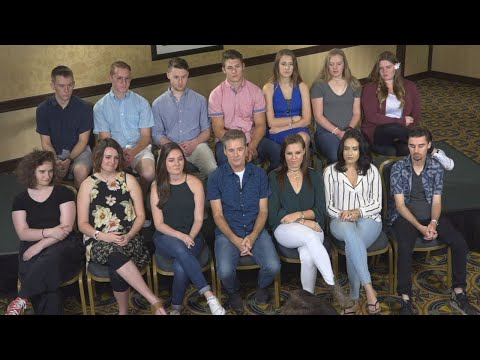

In [31]:
'''Interactive Demo'''

DEVELOPER_KEY = "USE_YOUR_OWN_KEY"
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"

def youtube_search_one(videoId, max_results=50, order="relevance", location=None, location_radius=None):

    youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION,developerKey=DEVELOPER_KEY)

    response = youtube.videos().list(
        part='snippet',
        id=videoId).execute()
    
    tags = response['items'][0]['snippet']['tags']
    categoryId = response['items'][0]['snippet']['categoryId'] 
    description = response['items'][0]['snippet']['description']
    description = description.replace('\n', " ").replace('\r', ' ')
    title = response['items'][0]['snippet']['title']

    # Get comments
    try:
        response2 = youtube.commentThreads().list(
            part="snippet",
            videoId=videoId,
            textFormat="plainText"
            ).execute()
        comments = ""

        i = 0
        if response2["items"] != None:
            for item in response2["items"]:
                i += 1
                comment = item["snippet"]["topLevelComment"]
                text = comment["snippet"]["textDisplay"]

                comments = comments + text + ":"
                if i == 10:
                    break
    except(HttpError) as e:
        comments = ""

    return int(categoryId), title, description, comments.replace('\n', " ").replace('\r', ' '), tags

  
def get_recommends(categoryId, emotion, tags):
    tag_str = " ".join(tags)
    df = pd.read_csv('youtube_all_class.csv', delimiter='\t', error_bad_lines=False, header=0)
    result = df[(df['categoryId'] == categoryId) & (df['tags'].apply(lambda x: SequenceMatcher(None,tag_str,str(x)).ratio() > 0.1)) & (df['emotion'] == emotion)].sort_values(by='likeCount', ascending=False)
    return result[:3]

  
def recommendation(clf, clf2):
    emotion = {1:'joy', 2:'angry', 3:'fear', 4:'sadness', 5:'surprise'}
    categories = {2:'Autos & Vehicles',1:' Film & Animation',10:'Music',15:'Pets & Animals',17:'Sports',18:'Short Movies',19:'Travel & Events',20:'Gaming',21:'Videoblogging',22:'People & Blogs',23:'Comedy',24:'Entertainment',25:'News & Politics',26:'Howto & Style',27:'Education',28:'Science & Technology',29:'Nonprofits & Activism',30:'Movies',31:'Anime/Animation',32:'Action/Adventure',33:'Classics',34:'Comedy',35:'Documentary',36:'Drama',37:'Family',38:'Foreign',39:'Horror',40:'Sci-Fi/Fantasy',41:'Thriller',42:'Shorts',43:'Shows',44:'Trailers'}
    videoId = str(input("Please enter a video id (eg. cihB6RKpylw):"))
    
    categoryId, title, description, comments, tags = youtube_search_one(videoId)
    strVideoData = title + " " + description + " " + comments + " ".join(tags)
    words = splitText(strVideoData)

    vocab = np.load('vocab.npy').item()
    vectorizer = TfidfVectorizer(vocabulary=vocab)
    X = vectorizer.fit_transform([words])
    pred_prob = clf.predict_proba(X)
    pred_prob2 = clf2.predict_proba(X)
    mult = pred_prob * pred_prob2
    pred = np.argmax(mult) + 1

    recommends = get_recommends(categoryId, pred, tags)
    
    print()
    print(title)
    print("The predicted emotion is: %s (category = %s)" % (emotion[pred], categories[categoryId]))
    print()
    print("The top 3 recommended video with similar emotion & category are:\n\n"+ \
          recommends.iloc[0, 1] + "\n" + recommends.iloc[1, 1] + "\n" + recommends.iloc[2, 1] + "\n")

    return recommends.iloc[0, 0], recommends.iloc[1, 0], recommends.iloc[2, 0]

id1, id2, id3 = recommendation(clf, clf_un)
YouTubeVideo(id1)

# Conclusion & Reference

In this project, the textual features of user-generated videos on Youtube (i.e. the video title, tag, description, and comments) were collected as data.  Then 2 approaches were used ML(supervised learning) and an emotion dictionary approach (unsupervised learning) to classify to emotion category. We conducted the sentiment analysis to classify the videos.Futhermore, the ML and emotion dictionary approach were combined to form ensemble models for recommendation system.<br>

The  accuracies which we got during our sentimental analysis using supervised learning was 57% whereas using unsupervised learning we were able to achieve accuracy of about 52.5%. Since we used 5 categories to predict the emotion, we found that few videos had very close probabilites for more than one emotion. The result shows that it is difficult to sometime differentiate between some emotions like fear and surprise. Here the classification rates attained using the emotion dictionary were unsatisfactory. This prediction accuracy is much better than a random guess which would be of 20% but it could be lower beacuse of multiple reasons like insufficient coverage of terms in the emotion dicitonary. <br>

In future, we would like to train our data with more data since here we had 14000 data set. Also, we would like to revaluate the emotion dictionary as NRC emotion lexicon has words mostly researched mostly on age group 25-40 years. We did indeed see that emotion , and not just positive or negative sentiment decides how people perceive video or any literature on the internet.





### References: 
* https://www.nrc-cnrc.gc.ca/eng/rd/ict/emotion_lexicons.html

* https://plot.ly/python/bar-charts/

* https://github.com/dpstart/youtube-sentiment-analysis/blob/master/sentiment.py

* https://docs.getindico.io/en/stable/

* https://developers.google.com/youtube/v3/

* https://www.sciencedirect.com/journal/decision-support-systems

* https://www.nltk.org

* http://scikit-learn.org/stable/